In [22]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error


In [23]:
# Imported Interbank FX Rates Historical.csv
Interbank_FX_Rates_Historical = pd.read_csv('./datasets/Interbank FX Rates Historical.csv')
# Deleted columns Currency, Currency Pair, Buying
Interbank_FX_Rates_Historical.drop(['Currency', 'Currency Pair', 'Buying','Mid Rate'], axis=1, inplace=True)
# Renamed columns GBPGHS
Interbank_FX_Rates_Historical.rename(columns={'Selling': 'GBPGHS'}, inplace=True)

In [24]:
# Imported Interbank FX Rates Historical (1).csv
Interbank_FX_Rates_Historical_1 = pd.read_csv('./datasets/Interbank FX Rates Historical (1).csv')
# Deleted columns Currency, Currency Pair, Buying
Interbank_FX_Rates_Historical_1.drop(['Currency', 'Currency Pair', 'Buying','Mid Rate'], axis=1, inplace=True)
# Renamed columns USDGHS
Interbank_FX_Rates_Historical_1.rename(columns={'Selling': 'USDGHS'}, inplace=True)

In [25]:
# Merged Interbank_FX_Rates_Historical_1 and Interbank_FX_Rates_Historical into df3
temp_df = Interbank_FX_Rates_Historical.drop_duplicates(subset=['Date']) # Remove duplicates so lookup merge only returns first match
df = Interbank_FX_Rates_Historical_1.merge(temp_df, left_on=['Date'], right_on=['Date'], how='left', suffixes=['_Interbank_FX_Rates_Historical_1', '_Interbank_FX_Rates_Historical'])
df.head()

,Date,USDGHS,GBPGHS
0,31 Dec 2020,7.8787,5.7631
1,30 Dec 2020,7.8087,5.7371
2,29 Dec 2020,7.7383,5.7351
3,24 Dec 2020,7.7779,5.7351
4,23 Dec 2020,7.7344,5.7241


In [26]:
# Check for missing values
print('missing values:', df.isnull().sum().sort_values(ascending = False))

missing values: Date      0
USDGHS    0
GBPGHS    0
dtype: int64


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3226 entries, 0 to 3225
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    3226 non-null   object
 1   USDGHS  3226 non-null   object
 2   GBPGHS  3226 non-null   object
dtypes: object(3)
memory usage: 100.8+ KB


In [28]:
df['USDGHS'] = pd.to_numeric(df['USDGHS'], errors='coerce')
df['GBPGHS'] = pd.to_numeric(df['GBPGHS'], errors='coerce')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
# Resample the DataFrame to a daily frequency and forward-fill missing values
df = df.resample('D').ffill()
df = df.fillna(method='bfill')
df.describe()

,USDGHS,GBPGHS
count,4748.000000,4748.000000
mean,4.320325,3.040635
std,1.846412,1.547481
min,0.000000,0.000000
25%,2.454700,1.522400
50%,4.878600,3.011850
75%,5.922800,4.404125
max,7.878700,5.763100


In [29]:
df_plot = df.copy()
df.head()

,USDGHS,GBPGHS
Date,,
2008-01-02,1.9427,0.9799
2008-01-03,1.9394,0.9799
2008-01-04,1.9309,0.9798
2008-01-05,1.9309,0.9798
2008-01-06,1.9309,0.9798


<AxesSubplot:xlabel='Date'>

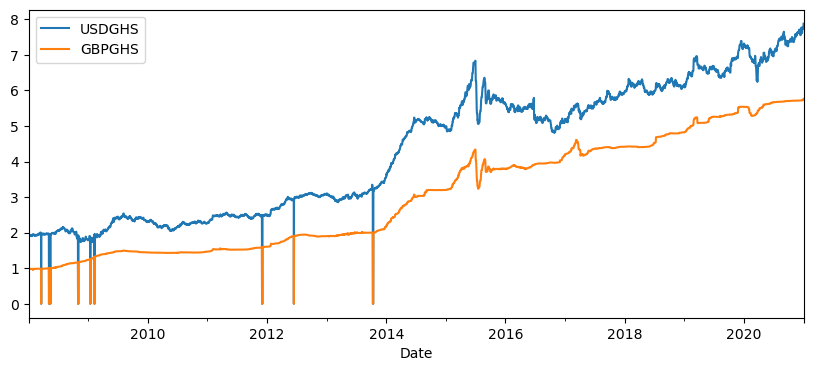

In [30]:
# Let's see a historical view of the closing price
df_plot['USDGHS'].plot(legend=True, figsize=(10,4))
df_plot['GBPGHS'].plot(legend=True, figsize=(10,4))

In [31]:
# Let's go ahead and plot out several moving averages
MA_day = [10,50,200]

for ma in MA_day:
    column_name = 'MA for %s days' %(str(ma))
    df_plot[column_name] = df_plot['USDGHS'].rolling(window=ma).mean()


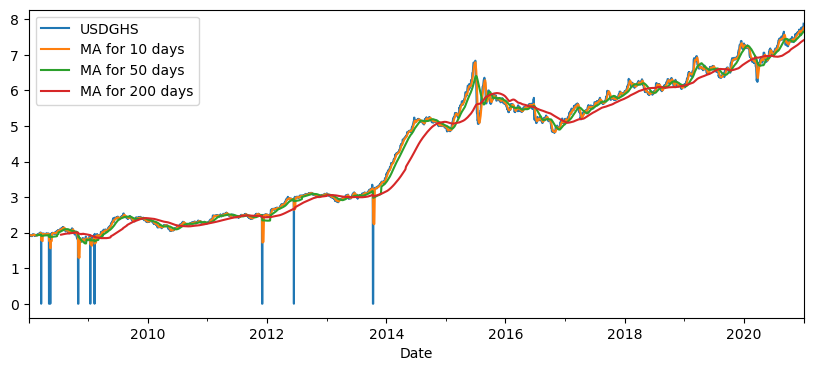

In [32]:
df_plot = df_plot[['USDGHS','MA for 10 days','MA for 50 days','MA for 200 days']].plot(subplots=False,figsize=(10,4))

In [33]:
df = df['USDGHS']
df.isnull().sum()

0

In [43]:
df_diff = df.copy()
# First and second order difference
df_diff = df_diff.diff()
df_diff2 = df_diff.diff(2)


In [47]:
df_diff = df_diff.dropna()
df_diff.head()

Date
2008-01-03   -0.0033
2008-01-04   -0.0085
2008-01-05    0.0000
2008-01-06    0.0000
2008-01-07    0.0034
Freq: D, Name: USDGHS, dtype: float64

In [48]:
df_diff.shape

(4747,)

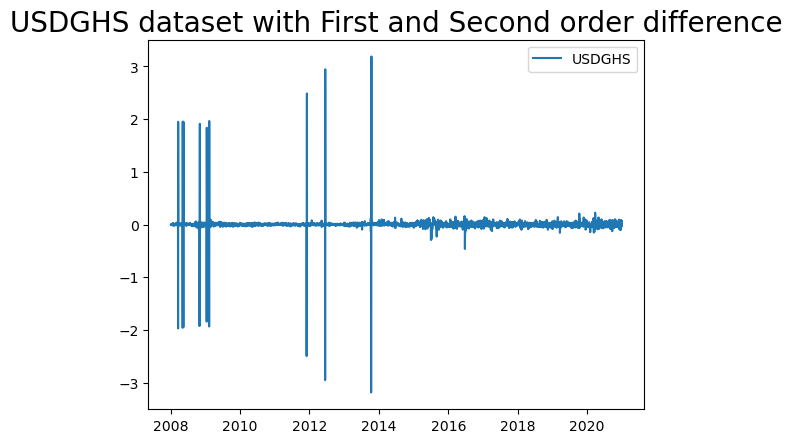

In [50]:

# Plot
plt.title('USDGHS dataset with First and Second order difference', size=20)
plt.plot(df_diff, label='USDGHS')
plt.legend();
plt.show()

It is not necessary to check for autocorrelation in time series before using LSTM. However, it is important to check for autocorrelation in time series data before using any time series model. Autocorrelation is a measure of the correlation between the values of a time series at different points in time. If there is autocorrelation in the data, it means that the values of the time series at one point in time are correlated with the values at other points in time. This can lead to biased estimates of the model parameters and can affect the accuracy of the model predictions

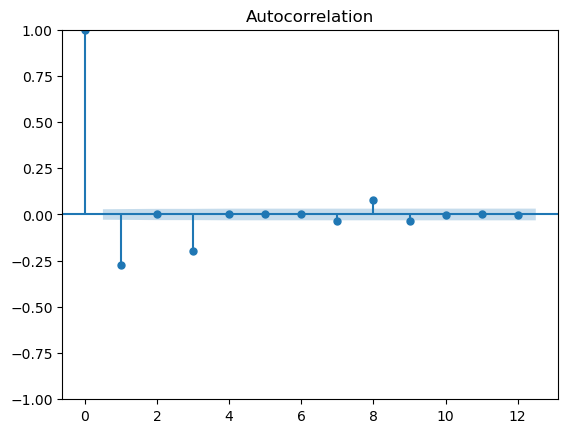

In [53]:
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt

#plot autocorrelation function
fig = tsaplots.plot_acf(df_diff, lags=12)
plt.show()

In [54]:
# Split the dataset into training, validation, and testing sets
train_df = df_diff.iloc[:int(len(df_diff)*0.6)]
val_df = df_diff.iloc[int(len(df_diff)*0.6):int(len(df_diff)*0.8)]
test_df = df_diff.iloc[int(len(df_diff)*0.8):]

In [56]:
# Define the neural network model
model = Sequential([
    Dense(32, activation='relu', input_shape=(1,)),
    Dense(16, activation='relu'),
    Dense(1)
])

In [57]:

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(train_df.values, 
                    train_df.values, 
                    validation_data=(val_df.values, val_df.values), 
                    epochs=100, batch_size=32)

Epoch 1/100
89/89 [==============================] - 6s 17ms/step - loss: 0.0294 - val_loss: 1.1464e-04
Epoch 2/100
89/89 [==============================] - 1s 8ms/step - loss: 0.0144 - val_loss: 1.3356e-04
Epoch 3/100
89/89 [==============================] - 1s 9ms/step - loss: 0.0063 - val_loss: 1.2653e-04
Epoch 4/100
89/89 [==============================] - 1s 10ms/step - loss: 0.0022 - val_loss: 1.2202e-04
Epoch 5/100
89/89 [==============================] - 1s 10ms/step - loss: 6.8811e-04 - val_loss: 1.3839e-04
Epoch 6/100
89/89 [==============================] - 1s 16ms/step - loss: 2.2139e-04 - val_loss: 8.3973e-05
Epoch 7/100
89/89 [==============================] - 1s 11ms/step - loss: 8.7129e-05 - val_loss: 4.6766e-05
Epoch 8/100
89/89 [==============================] - 1s 13ms/step - loss: 4.7304e-05 - val_loss: 2.0854e-05
Epoch 9/100
89/89 [==============================] - 1s 10ms/step - loss: 3.2971e-05 - val_loss: 1.7325e-05
Epoch 10/100
89/89 [==========================

In [58]:
history.history

{'loss': [0.029428774490952492,
  0.014436348341405392,
  0.006312428042292595,
  0.002223330782726407,
  0.0006881103035993874,
  0.00022138682834338397,
  8.712884300621226e-05,
  4.730384171125479e-05,
  3.297103103250265e-05,
  2.2450580217991956e-05,
  1.9876528313034214e-05,
  1.3665633559867274e-05,
  9.161591151496395e-06,
  7.695161912124604e-06,
  7.784210538375191e-06,
  5.873597729078028e-06,
  8.740946213947609e-06,
  6.053226115909638e-06,
  6.027669314789819e-06,
  5.9781641539302655e-06,
  6.283437869569752e-06,
  8.61445369082503e-06,
  5.110809979669284e-06,
  6.3004840740177315e-06,
  7.075607300066622e-06,
  1.5701178199378774e-05,
  1.2294136467971839e-05,
  9.480684639129322e-06,
  2.920477527368348e-06,
  4.487952082854463e-06,
  3.5637453947856557e-06,
  5.708106982638128e-06,
  8.133709343383089e-06,
  3.3597441415622598e-06,
  2.0536106148938416e-06,
  9.508932635071687e-06,
  3.74634146282915e-05,
  4.9666250561131164e-05,
  5.802095984108746e-06,
  1.1522069

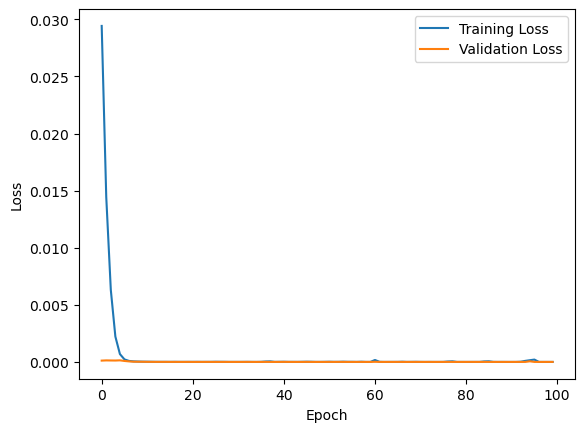

In [59]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [60]:

# Make predictions on the testing data
predictions = model.predict(test_df.values)

30/30 [==============================] - 2s 13ms/step


In [62]:
# Denormalize the predictions and actual values
predictions = predictions 
actual_values = test_df.values

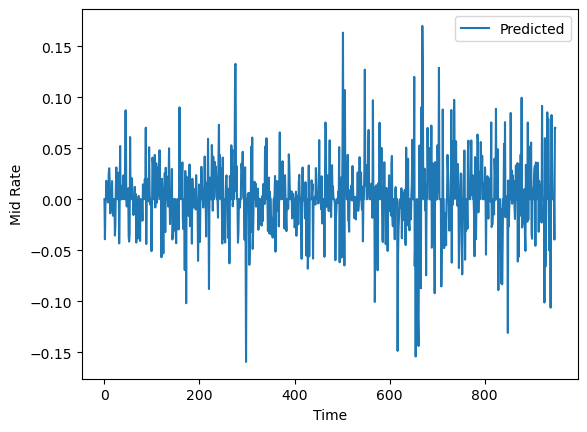

In [63]:
# Plot the predicted and actual values
plt.plot(predictions, label='Predicted')
#plt.plot(actual_values, label='Actual')
plt.xlabel('Time')
plt.ylabel('Mid Rate')
plt.legend()
plt.show()

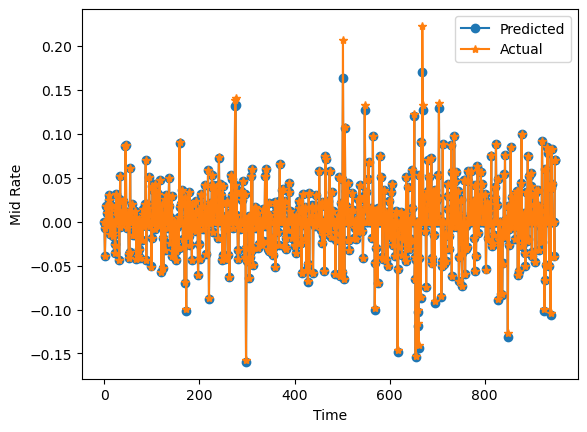

In [64]:
# Plot the predicted and actual values
plt.plot(predictions, marker = 'o' ,label='Predicted')
plt.plot(actual_values,marker = '*', label='Actual')
plt.xlabel('Time')
plt.ylabel('Mid Rate')
plt.legend()
plt.show()

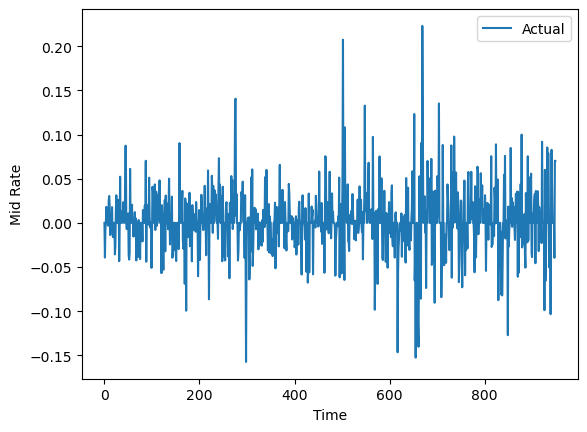

In [65]:
# Plot the predicted and actual values
#plt.plot(predictions, label='Predicted')
plt.plot(actual_values, label='Actual')
plt.xlabel('Time')
plt.ylabel('Mid Rate')
plt.legend()
plt.show()